# Тестовое задание
## Описание процесса
Есть производство некоторого продукта посредством электролиза (нагреваемый ящик, стоит в неотапливаемом помещении).
Заглядывать в ящик часто нельзя - лабораторный сбор по уточнению процентного содержания в смеси происходит дважды
в день, хотелось бы делать замеры еще реже  и в перспективе полагатсья только на модель - отсюда и задача. 
Требуется предсказать по данным (до 2018-10-18) с различных датчиков процентное содержание продукта в 
смеси файл `target.csv`.

## В качестве данных доступны

**Файл `3min Series (00sec) Outer new`**:

- `Шум` в электрике
- `Обратная ЭДС` сети устройства
- `Ср.прир.напр` Средний прирост напряжения в сети
- `Сум.доз АПГ` Сумма доз АПГ (происходит периодичный вброс катализатора в ящик - это число соответствует 
	кол-ву раз которое производилось вбрасывание за промежуток времени)
- Температурные датчики (ящик прямоугольной формы, они располагаются по всему периметру, см `boards.png` - 
![title](boards.jpg)
		схематическое расположение, нумерация вдоль длины ящика дана как пример)
	- `Board Temp. {i}` - датчики температуры по длине ящика с обоих сторон
	- `Board Face Temp. {1,6}` - датчики с лицевой стороны
	- `Board Deaf Temp. {1,6}` - датчики с тыльной стороны

**Файл `Средняя масса доли АПГ New`** : массовые доли каждого из вбросов показателя `Сумма доз АПГ`. 
То есть можно понять сколько массы было вброшено в период `Итог масс АПГ = Сум.доз АПГ * avg_mass_apg`.

## Критерии успешности выполнения задания:
- Получение инсайтов по данным
- Обоснованное построение модели
- Оценка полученной модели

In [1]:
import os
from tqdm.notebook import tqdm
import datetime
import zipfile

import numpy as np
# import tensorflow as tf
import pandas as pd
pd.options.display.max_rows, pd.options.display.max_columns = 500, 100

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import lightgbm
import optuna

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 4)
import seaborn as sns; sns.set()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # full screen width of Jupyter notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, FloatSlider

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ЗАГРУЗКА ДАННЫХ ИЗ АРХИВА
DATASET_PATH = ".\Тестовое_DS.zip"
inner_path = 'Тестовое_DS/тестовое задание/Data/'
reencode = lambda x: x.encode('CP866').decode('CP437')

with zipfile.ZipFile(DATASET_PATH) as z:
    
    # данные с приборов
    df = pd.read_csv(z.open(reencode(inner_path + '3min Series (00sec) Outer new.csv')),
                    parse_dates=['Date'],)
   
    # массовые доли каждого из вбросов показателя
    df_mass = pd.read_csv(z.open(reencode(inner_path + 'Средняя масса доли АПГ New.csv')),
                          parse_dates=['Dateparse'])

    # процентное содержание продукта в смеси
    df_target = pd.read_csv(z.open(reencode(inner_path + "target.csv")),
                    header=0, delimiter=";",
                    parse_dates=['Unnamed: 0'])                     
                        
df.shape, df_mass.shape, df_target.shape

((52269, 19), (2028, 2), (166, 2))

In [4]:
# ПЕРВИЧНАЯ ОБРАБОТКА ДАТАСЕТОВ

# Переименуем колонки для удобства
df.columns = ['timestamp', 'noise', 'emf', 'volt', 'sum_apg', 'bt1', 'bt2', 'bt3', 'bt4',
              'bt5', 'bt6', 'bt7', 'bt8','bt9', 'bt10', 'bt1f', 'bt6f', 'bt1d', 'bt6d']

df_mass.columns = ['timestamp', 'avg_mass_apg'] 

df_target.columns = ['timestamp', 'target']  

# Сдвинем df.timestamps на 2 минуты, чтобы датасеты совпадали в точках времени.
df.timestamp = df.timestamp + pd.to_timedelta('2min')

# добавим фичи времени в df
# df['time'] = df.timestamp.dt.time
df['date'] = df.timestamp.dt.date
df['minofday'] = df.timestamp.dt.minute + df.timestamp.dt.hour * 60  # minute of day

# Отсортируем df по времени
df = df.sort_values(by='timestamp')

# EDA

In [5]:
df.sample(5)

,timestamp,noise,emf,volt,sum_apg,bt1,bt2,bt3,bt4,bt5,bt6,bt7,bt8,bt9,bt10,bt1f,bt6f,bt1d,bt6d,date,minofday
22562,2018-09-15 23:39:00,0.012,2.178,-1.5,8.0,244.0,303.0,294.0,260.0,380.0,375.0,350.0,334.0,299.0,328.0,267.0,315.0,271.0,252.0,2018-09-15,1419
48845,2018-11-09 18:33:00,0.007,2.033,-1.2,7.0,237.0,287.0,301.0,231.0,341.0,317.0,310.0,300.0,350.0,301.0,260.0,300.0,219.0,237.0,2018-11-09,1113
26507,2018-09-24 04:54:00,0.009,1.853,-0.9,9.0,308.0,313.0,263.0,260.0,362.0,366.0,298.0,357.0,285.0,374.0,285.0,331.0,317.0,240.0,2018-09-24,294
34298,2018-10-10 10:33:00,0.012,2.084,NaN,7.0,326.0,359.0,296.0,272.0,388.0,388.0,290.0,355.0,331.0,380.0,319.0,340.0,340.0,324.0,2018-10-10,633
33800,2018-10-09 09:39:00,0.011,2.021,-0.5,6.0,313.0,336.0,267.0,262.0,362.0,262.0,370.0,340.0,299.0,366.0,299.0,343.0,334.0,264.0,2018-10-09,579


In [6]:
df_mass.sample(3)

,timestamp,avg_mass_apg
982,2018-09-09 21:00:00,0.488
1207,2018-09-19 06:00:00,0.516
392,2018-08-16 07:00:00,0.520


In [7]:
df_target.sample(3)

,timestamp,target
156,2018-10-14 05:00:00,NaN
98,2018-09-15 05:00:00,3.08
165,2018-10-18 14:00:00,NaN


## timestamp

In [8]:
# изучим основные параметры временных меток датасета

timestamps = {'df_ts':df.timestamp,
              'mass_ts':df_mass.timestamp,
              'target_ts':df_target.timestamp,
              'train_ts':df_target[~df_target.target.isna()].timestamp,
              'forecast_ts':df_target[df_target.target.isna()].timestamp}

for t_name, t in timestamps.items():
    print(f"{t_name:<12} min:{t.min()},  max:{t.max()},  count:{t.count():>5.0f},  isna:{t.isna().sum():.0f}")

df_ts        min:2018-07-27 22:48:00,  max:2018-11-13 22:45:00,  count:52269,  isna:0
mass_ts      min:2018-07-30 23:00:00,  max:2018-10-23 10:00:00,  count: 2028,  isna:0
target_ts    min:2018-07-28 05:00:00,  max:2018-10-18 14:00:00,  count:  166,  isna:0
train_ts     min:2018-07-28 05:00:00,  max:2018-10-01 05:00:00,  count:  131,  isna:0
forecast_ts  min:2018-10-01 14:00:00,  max:2018-10-18 14:00:00,  count:   35,  isna:0


In [9]:
# Рассмотрим стабильность интервалов между данными

print('df - интервалы между наблюдениями')
# df['t_step'] = df.timestamp.diff(periods=1)
# df.t_step.value_counts()
print(df.timestamp.diff(periods=1).value_counts())

print('\ndf - точки со значительными пропусками между наблюдениями')
df['t_step'] = df.timestamp.diff(periods=1)
print(df.loc[df['t_step'] > pd.to_timedelta('6min'),['timestamp','t_step']])
del df['t_step']

print('\ndf_mass - интервалы между наблюдениями')
print(df_mass.timestamp.diff(periods=1).value_counts())

print('\ndf_target - интервалы между наблюдениями')
print(df_target.timestamp.diff(periods=1).value_counts())

df - интервалы между наблюдениями
0 days 00:03:00    52250
0 days 00:06:00       12
0 days 00:09:00        4
0 days 00:36:00        1
0 days 01:03:00        1
Name: timestamp, dtype: int64

df - точки со значительными пропусками между наблюдениями
                timestamp          t_step
51849 2018-07-28 02:30:00 0 days 01:03:00
5026  2018-08-10 10:24:00 0 days 00:09:00
6594  2018-08-13 17:03:00 0 days 00:09:00
7391  2018-08-15 09:00:00 0 days 00:09:00
37702 2018-10-17 12:51:00 0 days 00:09:00
48166 2018-11-08 08:36:00 0 days 00:36:00

df_mass - интервалы между наблюдениями
0 days 01:00:00    2027
Name: timestamp, dtype: int64

df_target - интервалы между наблюдениями
0 days 09:00:00    83
0 days 15:00:00    82
Name: timestamp, dtype: int64


**наблюдения:** 

1) данные датчиков регистрируются в таблице df круглосуточно с интервалом 3 мин

2) данные массы регистрируются в таблице df_mass круглосуточно с интервалом 1 час

3) данные содержания продукта в смеси регистрируются в таблице df_target ежедневно, в 05:00 и 14:00

4) в таблице df есть небольшое количество (пропусков) в интервалах регистрации данных: 16 мелких и 2 крупных
<br>К счастью, 2 крупных пропуска находятся в начале изучаемого периода, где недостаточно данных о температуре, и позднее прогнозного периода. 

5) прогнозный интервал полностью покрыт данными датчиков и массы

## Noise

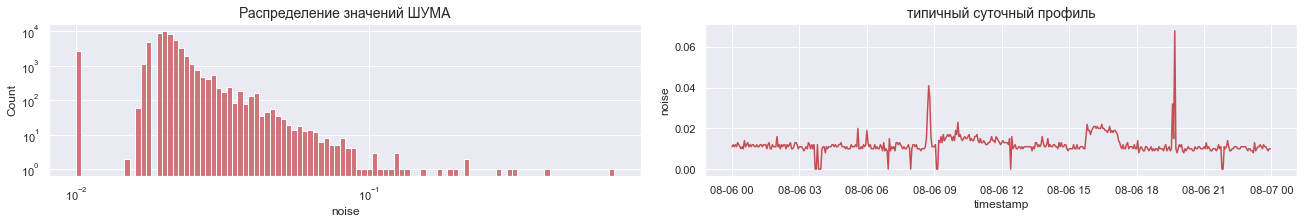

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(18, 3), constrained_layout=True)

axs[0].set_title('Распределение значений ШУМА', fontsize=14);
# sns.histplot(df.emf, bins=150, log_scale=[False,False], ax=axs[0]);
sns.histplot(df.noise+0.01, bins=100, log_scale=[True,True], ax=axs[0], color='r')

axs[1].set_title('типичный суточный профиль', fontsize=14);
chart_date = datetime.date(2018, 8, 6)
data = df.loc[df.date == chart_date,:]
sns.lineplot(x='timestamp',y='noise', data=data, ax=axs[1], color='r');

## ЭДС (EMF)

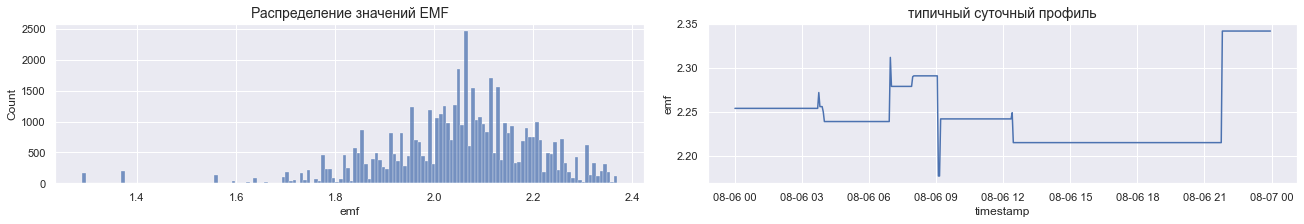

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(18, 3), constrained_layout=True)

axs[0].set_title('Распределение значений EMF', fontsize=14);
sns.histplot(df.emf, bins=150, log_scale=[False,False], ax=axs[0]);

axs[1].set_title('типичный суточный профиль', fontsize=14);
chart_date = datetime.date(2018, 8, 6)
data = df.loc[df.date == chart_date,:]
sns.lineplot(x='timestamp',y='emf', data=data, sizes=[1.5, 2.5], ax=axs[1]);

## Напряжение (volt)

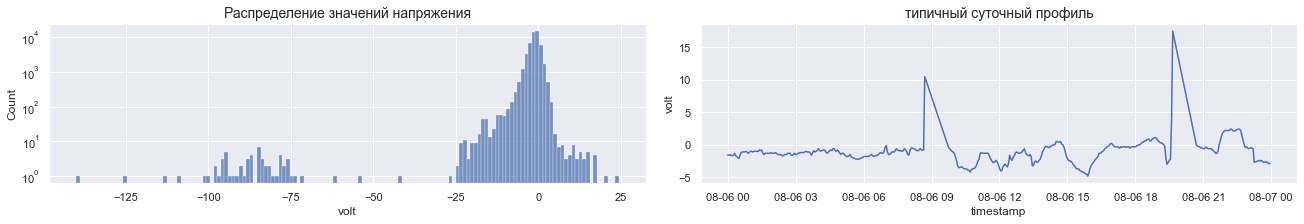

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(18, 3), constrained_layout=True)

axs[0].set_title('Распределение значений напряжения', fontsize=14);
sns.histplot(df.volt, bins=150, log_scale=[False,True], ax=axs[0]);

axs[1].set_title('типичный суточный профиль', fontsize=14);
chart_date = datetime.date(2018, 8, 6)
data = df.loc[df.date == chart_date,:]
sns.lineplot(x='timestamp',y='volt', data=data, sizes=[1.5, 2.5], ax=axs[1]);

### примеры выбросов напряжения вверх и вниз

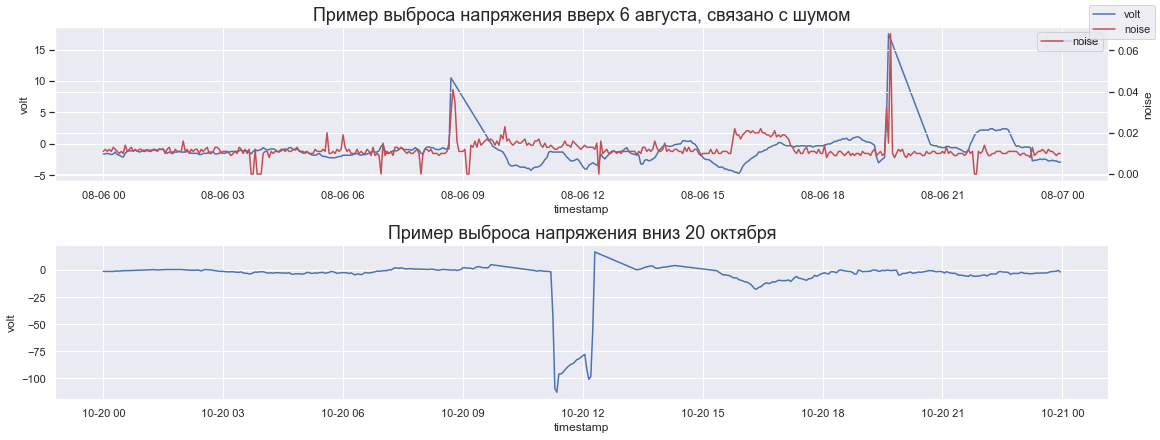

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 6), constrained_layout=True)

outlier_date = datetime.date(2018, 8, 6)
sns.lineplot(x='timestamp',y='volt',ax=axs[0], label = 'volt',
            data=df.loc[df.date == outlier_date,:])
ax02 = axs[0].twinx()
sns.lineplot(x='timestamp',y='noise',ax=ax02, color='r', label='noise',
            data=df.loc[df.date == outlier_date,:])
axs[0].set_title('Пример выброса напряжения вверх 6 августа, связано с шумом', fontsize=18)   
axs[0].figure.legend()

sns.lineplot(x='timestamp',y='volt', ax=axs[1],
            data=df.loc[df.date == datetime.date(2018, 10, 20),:],);
axs[1].set_title('Пример выброса напряжения вниз 20 октября', fontsize=18);

In [14]:
""" убираем выбросы показателей напряжения """

# remove outliers
df.loc[(df.volt.diff(periods=1)>1) & 
       ((df.volt.shift(periods=-1).isna())|(df.volt.shift(periods=-2).isna())),
       'volt'] = np.nan

df.loc[(df.volt<-25), 'volt'] = np.nan
# impute outliers with trend
df.volt = df.volt.interpolate(axis=0)

## Температура в баке (BT)

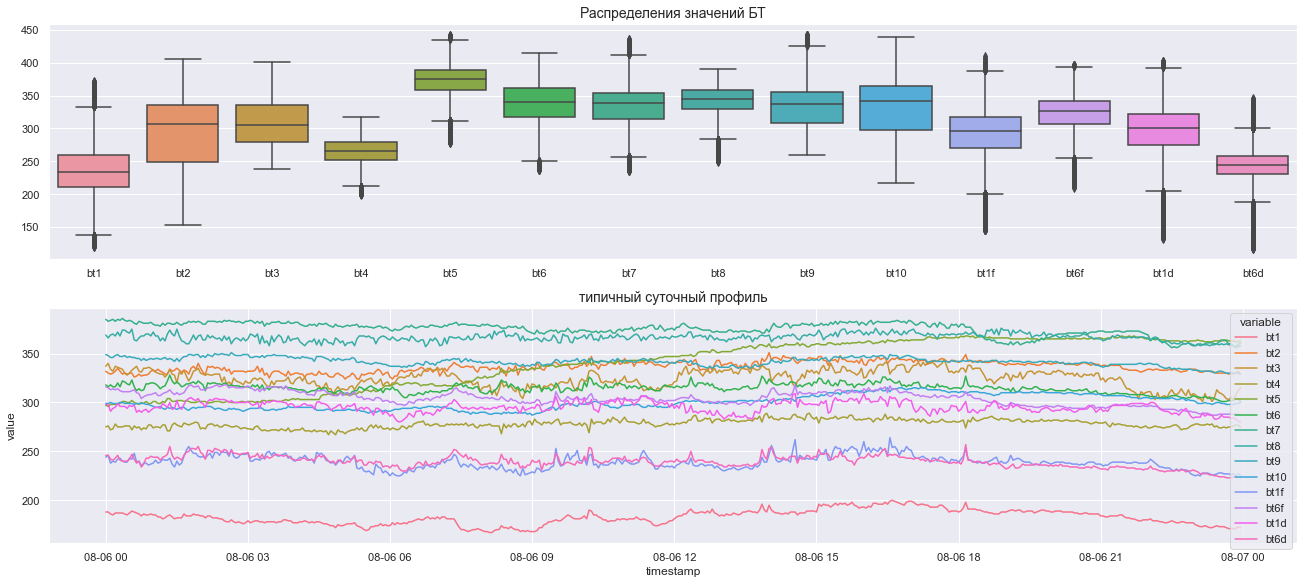

In [15]:
bt_cols = [c for c in df.columns if c[:2]=='bt']

fig, axs = plt.subplots(2, 1, figsize=(18, 8), constrained_layout=True)

axs[0].set_title('Распределения значений БТ', fontsize=14);
sns.boxplot (data=df[bt_cols], ax=axs[0])


axs[1].set_title('типичный суточный профиль', fontsize=14);
data = df.loc[df.date == chart_date, [*bt_cols, 'timestamp']]
data1 = pd.melt(data, ['timestamp'])
sns.lineplot(x='timestamp',  hue="variable", y='value', data=data1, ax=axs[1]);

In [16]:
# """ показатели рядов данных БТ """
# for bt in bt_cols:
#     print(f"{bt:<4} min:{df[bt].min()}, max:{df[bt].max()}, mean:{df[bt].mean():.0f}, std:{df[bt].std():.1f}")

In [17]:
# missing data in BT only on 4 specific days
df[df.bt1.isna()].date.unique()

array([datetime.date(2018, 7, 27), datetime.date(2018, 7, 28),
       datetime.date(2018, 7, 29), datetime.date(2018, 7, 30)],
      dtype=object)

недостающие данные BT находятся только в первые 4 дня обучающей выборки 

## sumary chart

In [18]:
dates_list = df.date.unique()
bt_cols = [c for c in df.columns if c[:2]=='bt' and c[2]!='_']

@interact  # note the decorator
def day_sensors_chart (selected_date=dates_list[4:]):  # default argument value as list
    day_data = df.loc[df.date == selected_date,:]
    
#    4 sensors' charts
    fig, axs = plt.subplots(4, 1, figsize=(16, 8), constrained_layout=True)
    sns.lineplot(x='timestamp',y='noise', data=day_data, ax = axs[0])
    sns.lineplot(x='timestamp',y='volt', data=day_data, ax = axs[1], estimator=None)
    sns.lineplot(x='timestamp',y='emf', data=day_data, ax = axs[2])
    sns.lineplot(x='timestamp',y='emf', data=day_data, ax = axs[1])
    sns.lineplot(x='timestamp',y='sum_apg', data=day_data, ax = axs[3])
    axs[3].set(ylim=(1.5, 2.5))

# temperatures chart    
    fig2, axs2 = plt.subplots(1, 1, figsize=(16, 4), constrained_layout=True)
    data0 = day_data.loc[:, [*bt_cols, 'timestamp']]
    data1 = pd.melt(data0, ['timestamp'])
    sns.lineplot(x='timestamp',  hue="variable", y='value', data=data1, ax = axs2);

#     day_data = df.loc[df.date == date,:]

# Interactive temperature chart
    bt_labels = np.asarray([['bt1f', 'bt10', 'bt9', 'bt8', 'bt7', 'bt6f'],
                            ['bt1', 'bt10', 'bt9', 'bt8', 'bt7', 'bt6'],
                            ['bt1', 'bt2', 'bt3', 'bt4', 'bt5', 'bt6'],
                            ['bt1d', 'bt2', 'bt3', 'bt4', 'bt5', 'bt6d'],])

    def bt_heatmap(minute_of_day):
        fig, ax = plt.subplots(figsize=(16, 3))
        snapshot=day_data.loc[(day_data.minofday == minute_of_day)]
        print("observation timestamp:", snapshot.timestamp.dt.strftime('%Y-%m-%d %H:%M:%S').values[0])
        sns.heatmap(snapshot[bt_labels.flatten()].values.reshape(4, 6),
                    vmin=100, vmax=500, ax=ax,
                    annot=bt_labels, fmt='', annot_kws={"size": 20})

    interact(bt_heatmap, minute_of_day=FloatSlider(min=0, max=24*60-3, step=3, continuous_update=False));

#     for ax, did in zip (axs.ravel(), dept_list[:]):

interactive(children=(Dropdown(description='selected_date', options=(datetime.date(2018, 7, 31), datetime.date…

## Матрица корреляции

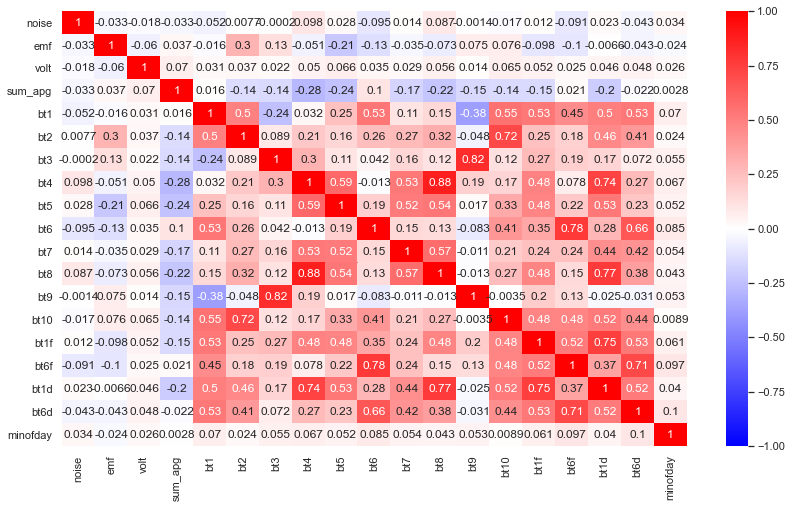

In [19]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize = (14,8))
sns.heatmap(corrMatrix, annot=True, ax=ax, cmap = 'bwr', vmin=-1);

## mass data

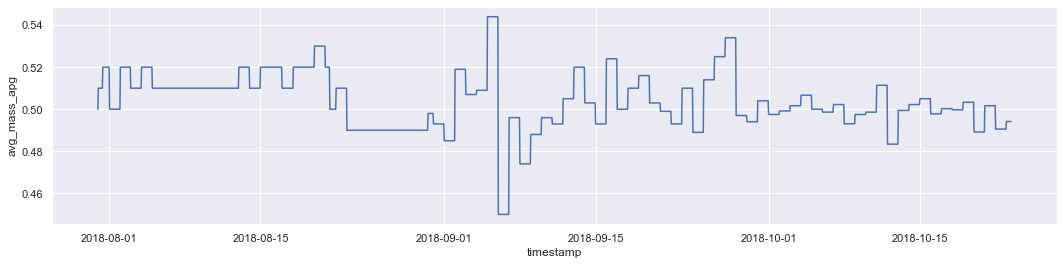

In [20]:
sns.lineplot(x='timestamp',y='avg_mass_apg', data=df_mass);

In [21]:
"""данные о массе АПГ добавим в основную таблицу. """
df = df.merge(df_mass, on='timestamp', how='left') # присоединяем данные о массе
df.avg_mass_apg = df.avg_mass_apg.fillna(method='ffill') # заполняем пробелы вперёд
df['apg'] = df.avg_mass_apg * df.sum_apg  # рассчитываем вес добавлений АПГ согласно условий

## Target data

<AxesSubplot:xlabel='timestamp', ylabel='target'>

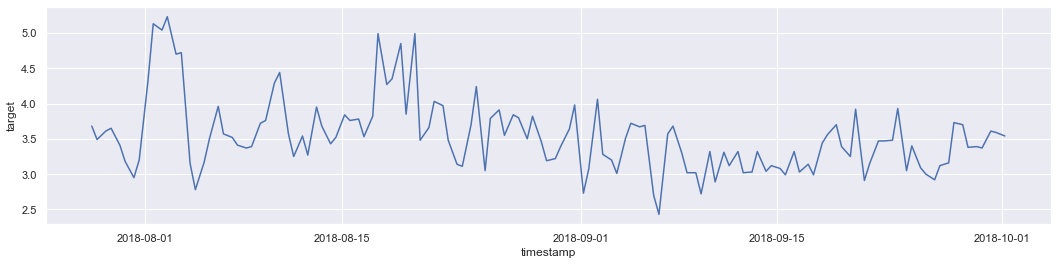

In [22]:
sns.lineplot(x='timestamp',y='target', data=df_target)

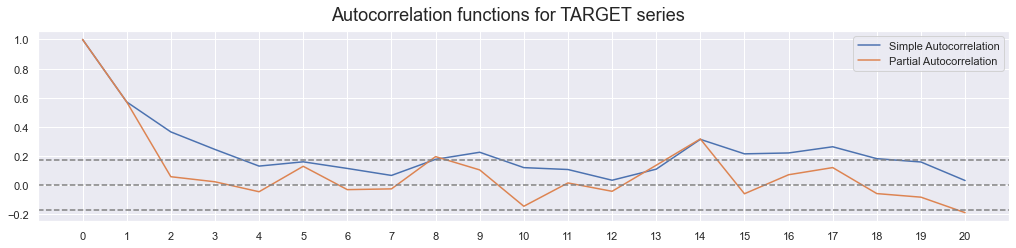

In [23]:
from statsmodels.tsa.stattools import acf, pacf

def plot_autocorrelations(series, suptitle='', lags=20):
    fig, ax = plt.subplots(1, 1, figsize=(14, 3), constrained_layout=True)
   
    plt.plot(acf(series, nlags=lags, fft=False),
             label='Simple Autocorrelation')
    plt.plot(pacf(series, nlags=lags, method='ols'),
             label='Partial Autocorrelation')
    ax.axhline(y=0,linestyle='--',color='gray')
    ax.axhline(y=-1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    ax.axhline(y=1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    ax.set_xticks(range(lags+1))
    ax.legend(loc='best')
        
    suptitle = f'Autocorrelation functions for {suptitle} series'
    plt.suptitle (suptitle, fontsize = 18, y=1.1)

plot_autocorrelations(df_target.target.dropna(), 'TARGET', 20)

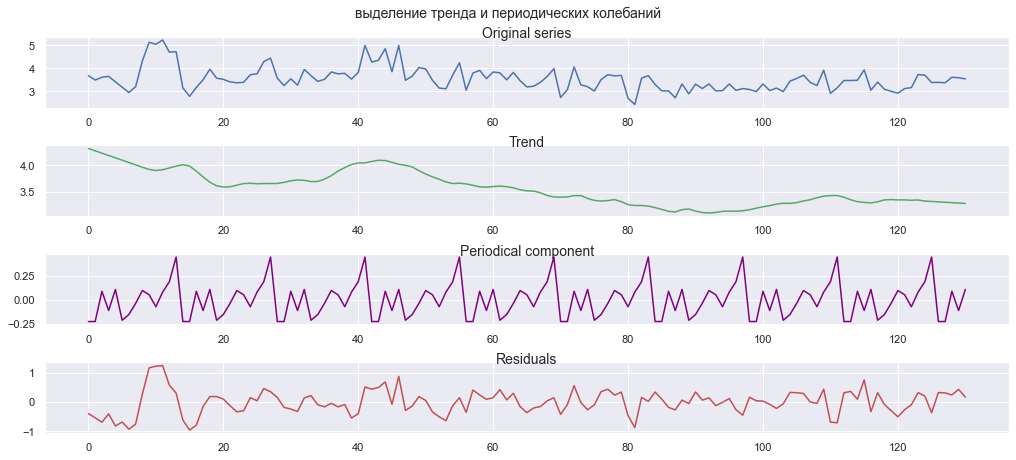

In [24]:
""" Seasonal decomposition"""

from statsmodels.tsa.seasonal import seasonal_decompose

def plot_decomposition(decomposition, series):
    fig, axs = plt.subplots(4, 1, figsize=(14, 6), constrained_layout=True)
    plt.suptitle(f'выделение тренда и периодических колебаний',
                 fontsize=14, y=1.04)
    axs[0].plot(series)
    axs[0].set_title('Original series', fontsize=14,  y=0.9)
    axs[1].plot(decomposition.trend, label='Trend', c='g')
    axs[1].set_title('Trend', fontsize=14,  y=0.9)
    axs[2].plot(decomposition.seasonal[:1000],label='periodicity', c='purple') # show first 1000 to avoid compression
    axs[2].set_title('Periodical component', fontsize=14,  y=0.9)
    axs[3].plot(decomposition.resid, label='Residuals', c='r')
    axs[3].set_title('Residuals', fontsize=14,  y=0.9)

series = df_target.target.dropna().values
decomposition = seasonal_decompose(series, period=14, extrapolate_trend=True)
plot_decomposition(decomposition, series)

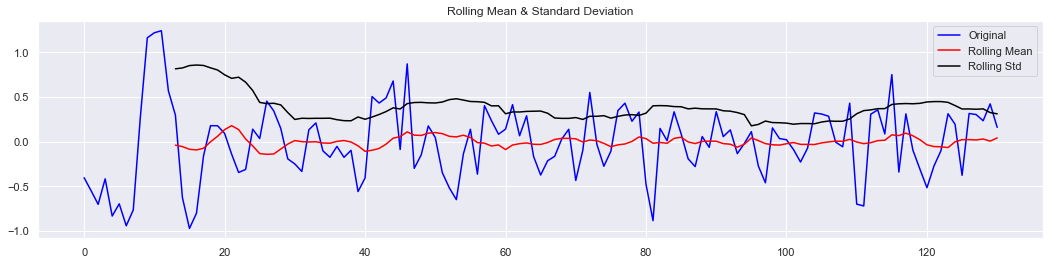

Results of Dickey-Fuller Test:
Test Statistic                -7.259062e+00
p-value                        1.700348e-10
#Lags Used                     1.100000e+01
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64


In [25]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=12):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# test_stationarity(df_target.target.dropna(), 14)
test_stationarity(pd.Series(decomposition.resid).dropna(), 14)

# Выводы. 

Анализ временного ряда целевого показателя выявил наличие тренда и недельной цикличности. После их выделения остатки стационарны. Для учета цикличности введем категорийную переменную "день недели". Тренд предлагаю игнорировать, т.к.данный производственный процесс не предполагает долгосрочного тренда.

При отсутствии тренда и автокорреляции данная задача должна решаться не как прогноззирование временных рядов, а как регрессия, основанная на показателях в момент замера концентрации и в период, непосредственно предшедствующий измерению.

В качестве мерики точности выберем RMSE

# Регрессионные модели

In [38]:
df[~df.part.isna()]

,timestamp,noise,emf,volt,sum_apg,bt1,bt2,bt3,bt4,bt5,bt6,bt7,bt8,bt9,bt10,bt1f,bt6f,bt1d,bt6d,date,minofday,avg_mass_apg,apg,target,part
104,2018-07-28 05:00:00,NaN,NaN,-1.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28,300,NaN,NaN,3.68,train
284,2018-07-28 14:00:00,NaN,NaN,-1.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-28,840,NaN,NaN,3.49,train
583,2018-07-29 05:00:00,0.012,2.367,-3.700000,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-29,300,NaN,NaN,3.61,train
763,2018-07-29 14:00:00,0.015,2.354,-1.800000,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-29,840,NaN,NaN,3.65,train
1063,2018-07-30 05:00:00,0.009,2.284,-0.500000,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-30,300,NaN,NaN,3.41,train
1243,2018-07-30 14:00:00,0.012,2.284,-0.900000,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-30,840,NaN,NaN,3.18,train
1543,2018-07-31 05:00:00,0.000,2.346,-0.500000,8.0,233.0,308.0,279.0,264.0,334.0,309.0,243.0,354.0,318.0,319.0,299.0,285.0,250.0,191.0,2018-07-31,300,0.510000,4.080000,2.95,train
1723,2018-07-31 14:00:00,0.015,2.053,-1.300000,7.0,264.0,303.0,298.0,272.0,352.0,330.0,256.0,363.0,320.0,311.0,304.0,299.0,264.0,236.0,2018-07-31,840,0.520000,3.640000,3.20,train
2023,2018-08-01 05:00:00,0.013,2.147,-1.800000,8.0,273.0,353.0,308.0,285.0,419.0,387.0,408.0,377.0,343.0,386.0,344.0,344.0,286.0,260.0,2018-08-01,300,0.500000,4.000000,4.32,train
2202,2018-08-01 14:00:00,0.000,2.104,2.900000,6.0,333.0,381.0,344.0,305.0,418.0,331.0,385.0,377.0,371.0,398.0,384.0,349.0,327.0,267.0,2018-08-01,840,0.500000,3.000000,5.13,train


In [27]:
"""добавим данные о содержании продукта"""
df = df.merge(df_target.fillna(-1), on='timestamp', how='left')

In [69]:
"""Расставим метки для разделения выборки на обучающую, валидационную и тестовую"""

df.loc[df.target > 0,'part'] = 'train'

df.loc[df.target == -1,'part'] = 'test'

val_share = 0.2
val_count = int(val_share * df.loc[df.part == 'train'].shape[0])
val_index = df.loc[df.part == 'train','part'][-val_count:].index
df.loc[val_index, 'part'] = 'val'

df.part.value_counts()

train    105
test      35
val       26
Name: part, dtype: int64

### prepare and split dataset

In [70]:
""" build datasets """
def bulid_train_test_sets(df_, train_cols_, test_size=0.2):
    X = df_.loc[:, train_cols_]
    X = X.fillna(method='backfill').values
    y = df_.loc[:, 'target'].values

    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train.shape, X_val.shape
    return X_train, X_val, y_train, y_val

excluded_columns = ['part', 'target', 'avg_mass_apg', 'sum_apg', 'timestamp', 'date']
train_cols = [c for c in df.columns if c not in excluded_columns]

df_ = df[df.part.isin(['train', 'val'])]

X_train, X_val, y_train, y_val = bulid_train_test_sets(df_, train_cols, test_size=0.2)
train_index = range(len(y_train))
val_index = range(len(y_train), len(y_train)+len(y_val))

In [71]:
""" Helper functions for charting """

def plot_series(y_train, y_val, y_forecast, y_pred=None, title=''):
    fix, ax = plt.subplots()
    ax.plot(train_index, y_train, label='train', c='blue')
    if y_pred is not None:
        ax.plot(train_index, y_pred, label='predict', c='gray')
    ax.plot(val_index, y_val, label='val', c='green')
    ax.plot(val_index, y_forecast, label='forecast', c='orange')
    ax.legend();
    ax.set_title(title, fontsize=20)
    
def importance_chart(importances, feature_names, num_features=10, title=''):
    imp_dict = {feature:importance for feature, importance in
                   zip(train_cols, importances)}
    imp_dict = {k: v for k, v in sorted(imp_dict.items(), key=lambda x: x[1])[-num_features:]}
    fix, ax = plt.subplots(figsize=(16, num_features//5 + 1))
    ax.barh(width = imp_dict.values(), y = list(imp_dict.keys()))
    ax.set_title (title, fontsize=20)

### ARIMA (в качестве baseline)

ARIMA RMSE result: 0.6157


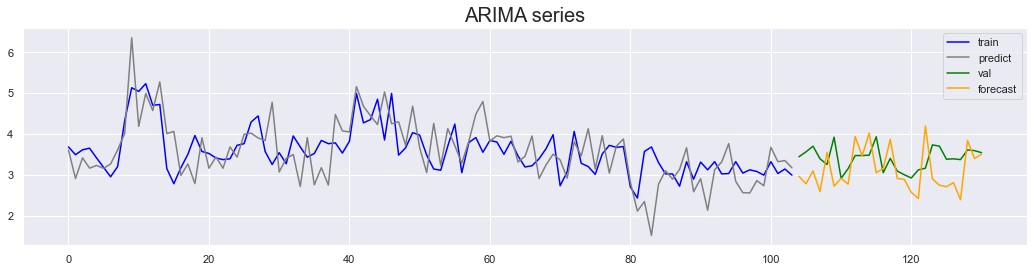

In [72]:
from statsmodels.tsa.arima.model import ARIMA
# methods = ['innovations_mle', 'hannan_rissanen', 'burg', 'innovations','yule_walker', 'statespace']

model = ARIMA(endog = y_train, exog = X_train, enforce_stationarity=True)
res = model.fit(method='statespace', )

y_pred = res.predict(min(train_index), max(train_index))
y_forecast = res.predict(min(val_index), max(val_index), exog=X_val)

print (f"ARIMA RMSE result: {sm.tools.eval_measures.rmse(y_val, y_forecast):.4f}")

plot_series(y_train, y_val, y_forecast, y_pred, title='ARIMA series')    

### SARIMAX

SARIMAX RMSE result: 0.5828


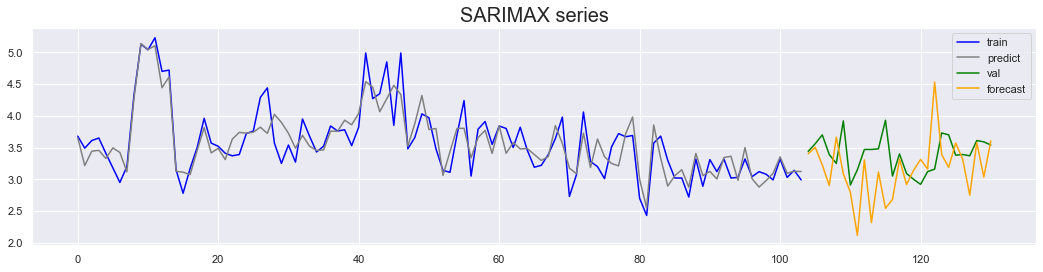

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(endog = y_train, exog = X_train, enforce_stationarity=True)
res = model.fit()

y_pred = res.predict(min(train_index), max(train_index))
y_forecast = res.predict(min(val_index), max(val_index), exog=X_val)

print (f"SARIMAX RMSE result: {sm.tools.eval_measures.rmse(y_val, y_forecast):.4f}")

plot_series(y_train, y_val, y_forecast, y_pred, title='SARIMAX series')    

### Random forest

Random Forest RMSE result: 0.5078


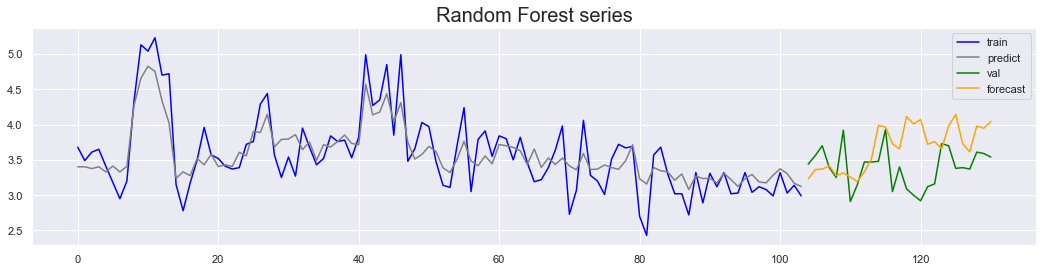

In [74]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=0)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_train)
y_forecast = forest.predict(X_val)

print (f"Random Forest RMSE result: {sm.tools.eval_measures.rmse(y_val, y_forecast):.4f}")

plot_series(y_train, y_val, y_forecast, y_pred, title='Random Forest series')    

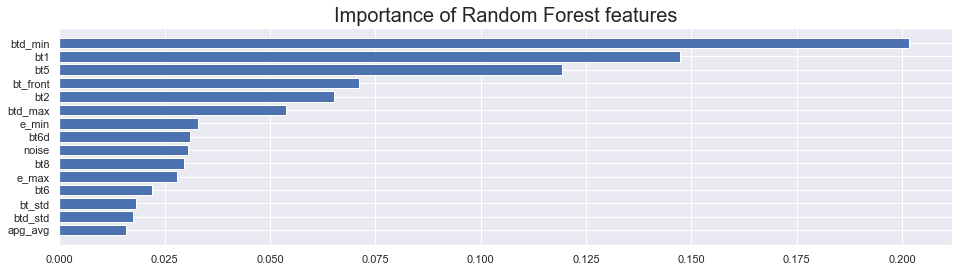

In [75]:
importance_chart(forest.feature_importances_, train_cols, num_features = 15,
                 title='Importance of Random Forest features')

### LightGBM - original features

In [76]:
cat_features = ['minofday']
train_data = lightgbm.Dataset(X_train, label=y_train,
                              categorical_feature=cat_features,
                             feature_name = train_cols)
val_data = lightgbm.Dataset(X_val, label=y_val,
                            categorical_feature=cat_features,)

lgb_parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 5,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'min_data_in_leaf': 4,
    'force_col_wise':True,
}

model = lightgbm.train(lgb_parameters, train_data, valid_sets=val_data,
                       num_boost_round=100, early_stopping_rounds=5,
                      verbose_eval=False)

y_pred = model.predict(X_train)
y_forecast = model.predict(X_val)
print (f"LGBM RMSE result: {sm.tools.eval_measures.rmse(y_val, y_forecast):.4f} after {model.current_iteration()} iters")

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
LGBM RMSE result: 0.2606 after 19 iters


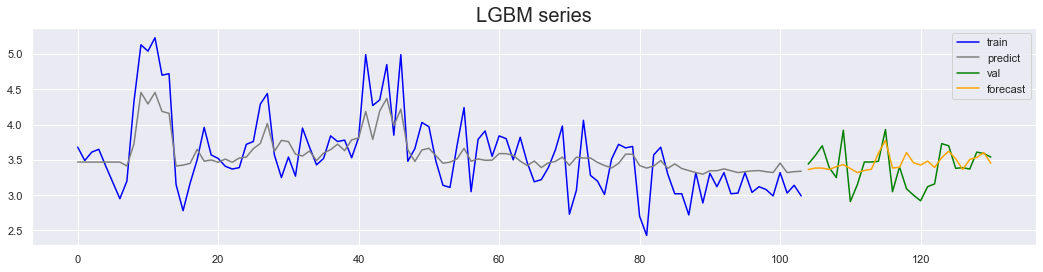

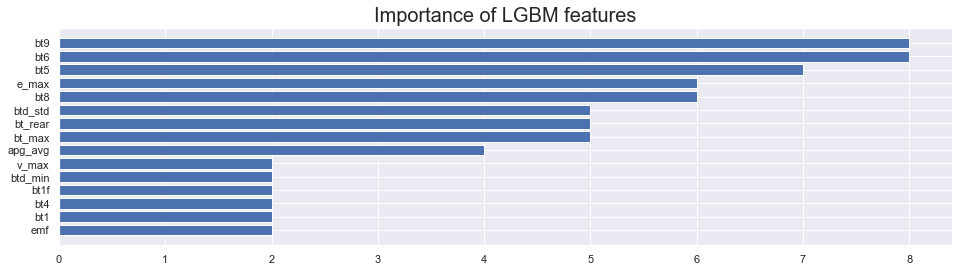

In [77]:
plot_series(y_train, y_val, y_forecast, y_pred, title='LGBM series')    

importance_chart(model.feature_importance(), model.feature_name, num_features = 15,
                 title='Importance of LGBM features')

# Feature engineering

In [78]:
df['dow'] = df['timestamp'].dt.dayofweek.astype('int')

In [79]:
# BT Statistics

# показатели температуры на момент измерения
df['bt_min'] = df[bt_cols].min(axis=1)
df['bt_max'] = df[bt_cols].max(axis=1)
df['bt_std'] = df[bt_cols].std(axis=1).round(2)
df['bt_avg'] = df[bt_cols].mean(axis=1).round(1)

# показатели температуры по краям бака на момент измерения
bt_front = ['bt1f', 'bt10', 'bt9', 'bt8', 'bt7', 'bt6f']
bt_rear = ['bt1d', 'bt2', 'bt3', 'bt4', 'bt5', 'bt6d']
bt_left = ['bt6f','bt6','bt6d', 'bt5', 'bt7']
bt_right = ['bt1f','bt1','bt1d','bt2','bt10']
df['bt_front'] = df[bt_front].mean(axis=1).round(1)
df['bt_rear'] = df[bt_rear].mean(axis=1).round(1)
df['bt_left'] = df[bt_left].mean(axis=1).round(1)
df['bt_right'] = df[bt_right].mean(axis=1).round(1)

In [80]:
window = 60  # окно измерения показателей, 3 часа, 60 измерений
# use 'btd' prefix for BT features with Dynamics

df['btd_min'] = df.bt_avg.rolling(window).min()
df['btd_max'] = df.bt_avg.rolling(window).max()
df['btd_std'] = df.bt_avg.rolling(window).std().round(2)

df['bt_lr_diff'] = df.bt_left.rolling(window).agg(np.mean) - df.bt_right.rolling(window).agg(np.mean)
df['bt_fr_diff'] = df.bt_front.rolling(window).agg(np.mean) - df.bt_rear.rolling(window).agg(np.mean)

df['v_min'] = df.volt.rolling(window).min()
df['v_max'] = df.volt.rolling(window).max()
df['v_std'] = df.volt.rolling(window).std().round(3)

df['e_min'] = df.emf.rolling(window).min()
df['e_max'] = df.emf.rolling(window).max()
df['e_std'] = df.emf.rolling(window).std().round(3)

df['volt_ch'] = df.volt - df.volt.shift(window)
df['emf_ch'] = df.emf - df.emf.shift(window)
df['bt_ch'] = df.bt_avg - df.bt_avg.shift(window)

df['apg_avg'] = df.apg.rolling(window).mean().round(3)

In [81]:
df.sample(5)

,timestamp,noise,emf,volt,sum_apg,bt1,bt2,bt3,bt4,bt5,bt6,bt7,bt8,bt9,bt10,bt1f,bt6f,bt1d,bt6d,date,minofday,avg_mass_apg,apg,target,part,dow,bt_min,bt_max,bt_std,bt_avg,bt_front,bt_rear,bt_left,bt_right,btd_min,btd_max,btd_std,bt_lr_diff,bt_fr_diff,v_min,v_max,v_std,e_min,e_max,e_std,volt_ch,emf_ch,bt_ch,apg_avg
49550,2018-11-08 06:18:00,0.009,2.061,-1.3,6.0,228.0,280.0,303.0,234.0,372.0,359.0,320.0,306.0,358.0,338.0,256.0,358.0,212.0,240.0,2018-11-08,378,0.494167,2.965,NaN,NaN,3,212.0,372.0,55.75,297.4,322.7,273.5,329.8,262.8,288.5,299.3,2.41,67.930000,52.455000,-3.4,-0.4,0.743,2.061,2.061,0.000,-0.5,0.000,8.1,2.751
50412,2018-11-10 01:57:00,0.010,1.820,-3.9,6.0,216.0,258.0,276.0,210.0,316.0,273.0,301.0,283.0,334.0,296.0,228.0,258.0,192.0,149.0,2018-11-10,117,0.494167,2.965,NaN,NaN,5,149.0,334.0,51.72,256.4,283.3,233.5,259.4,238.0,255.4,270.4,4.24,30.706667,47.753333,-9.0,1.2,2.715,1.820,1.820,0.000,-3.6,0.000,-10.7,3.130
23133,2018-09-14 05:15:00,0.011,1.879,-2.1,8.0,212.0,286.0,280.0,244.0,345.0,307.0,297.0,318.0,295.0,307.0,243.0,284.0,259.0,214.0,2018-09-14,315,0.503000,4.024,NaN,NaN,4,212.0,345.0,38.95,277.9,290.7,271.3,289.4,261.4,277.9,284.4,1.62,21.896667,21.845000,-2.5,0.9,0.678,1.879,1.879,0.000,-1.6,0.000,-6.2,3.638
24934,2018-09-17 23:18:00,0.008,2.204,-2.7,10.0,225.0,283.0,275.0,239.0,362.0,346.0,336.0,322.0,286.0,351.0,266.0,317.0,259.0,236.0,2018-09-17,1398,0.500000,5.000,NaN,NaN,0,225.0,362.0,45.87,293.1,313.0,275.7,319.4,276.8,284.8,297.2,2.99,41.063333,37.930000,-4.3,0.0,1.088,2.204,2.269,0.015,-2.5,-0.041,7.4,3.608
3188,2018-08-03 15:21:00,0.017,1.704,0.3,6.0,245.0,352.0,348.0,289.0,372.0,315.0,350.0,367.0,352.0,311.0,266.0,278.0,319.0,253.0,2018-08-03,921,0.510000,3.060,NaN,NaN,4,245.0,372.0,43.17,315.5,320.7,322.2,313.6,298.6,314.1,325.2,2.95,14.670000,-0.860000,-2.2,3.7,1.555,1.704,2.228,0.226,-1.0,-0.524,-5.6,2.286


In [82]:
excluded_columns = ['part', 'target', 'noise', 'avg_mass_apg', 'sum_apg', 'timestamp', 'date', *bt_cols]
train_cols = [c for c in df.columns if c not in excluded_columns]
print (train_cols)

df_ = df.loc[df.part.isin(['train', 'val']), ['target', *train_cols]]

X_train, X_val, y_train, y_val = bulid_train_test_sets(df_, train_cols, test_size=0.2)

['emf', 'volt', 'minofday', 'apg', 'dow', 'bt_min', 'bt_max', 'bt_std', 'bt_avg', 'bt_front', 'bt_rear', 'bt_left', 'bt_right', 'btd_min', 'btd_max', 'btd_std', 'bt_lr_diff', 'bt_fr_diff', 'v_min', 'v_max', 'v_std', 'e_min', 'e_max', 'e_std', 'volt_ch', 'emf_ch', 'bt_ch', 'apg_avg']


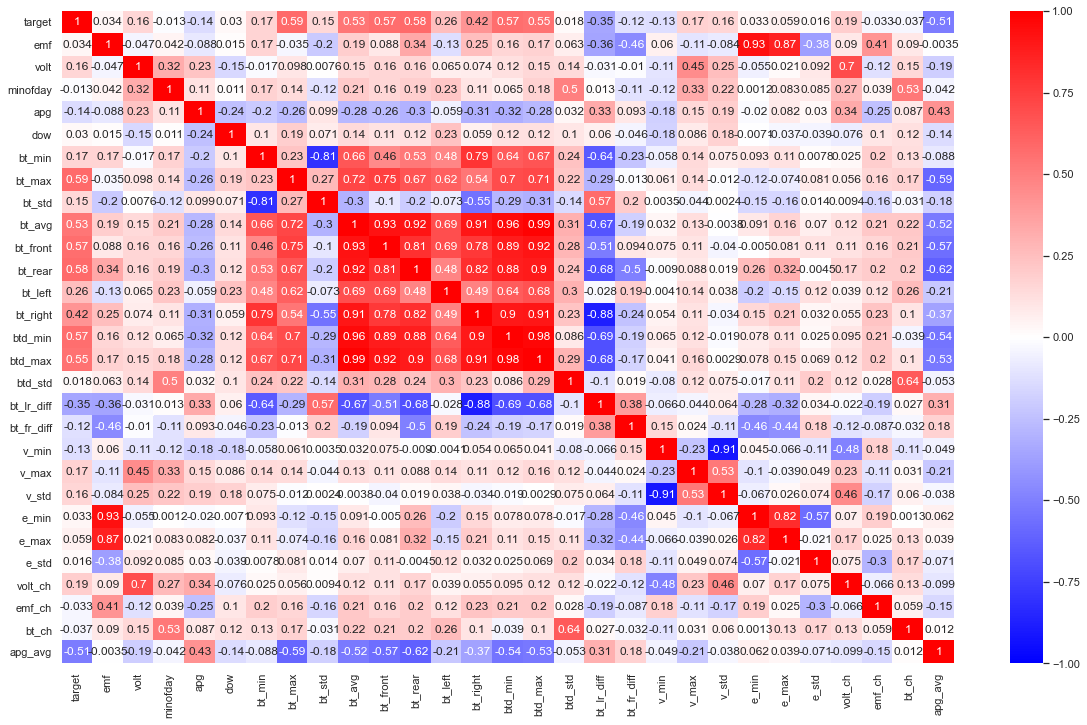

In [83]:
corrMatrix = df_.corr()
fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(corrMatrix, annot=True, ax=ax, cmap = 'bwr', vmin=-1);

### LightGBM with new features

In [84]:
excluded_columns = ['part', 'target', 'noise', 'avg_mass_apg', 'sum_apg', 'timestamp', 'date'] # , *bt_cols]
train_cols = [c for c in df.columns if c not in excluded_columns]
print (train_cols)

df_ = df.loc[df.part.isin(['train', 'val']), ['target', *train_cols]]

X_train, X_val, y_train, y_val = bulid_train_test_sets(df_, train_cols, test_size=0.2)

['emf', 'volt', 'bt1', 'bt2', 'bt3', 'bt4', 'bt5', 'bt6', 'bt7', 'bt8', 'bt9', 'bt10', 'bt1f', 'bt6f', 'bt1d', 'bt6d', 'minofday', 'apg', 'dow', 'bt_min', 'bt_max', 'bt_std', 'bt_avg', 'bt_front', 'bt_rear', 'bt_left', 'bt_right', 'btd_min', 'btd_max', 'btd_std', 'bt_lr_diff', 'bt_fr_diff', 'v_min', 'v_max', 'v_std', 'e_min', 'e_max', 'e_std', 'volt_ch', 'emf_ch', 'bt_ch', 'apg_avg']


In [85]:
cat_features = ['minofday', 'dow']
train_data = lightgbm.Dataset(X_train, label=y_train,
                              categorical_feature=cat_features,
                             feature_name = train_cols,
                             free_raw_data=False)
val_data = lightgbm.Dataset(X_val, label=y_val,
                            categorical_feature=cat_features,)

lgb_parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 5,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'min_data_in_leaf': 4,
    'force_col_wise':True,
}

model = lightgbm.train(lgb_parameters, train_data, valid_sets=val_data,
                       num_boost_round=100, early_stopping_rounds=5,
                      verbose_eval=False)

y_pred = model.predict(X_train)
y_forecast = model.predict(X_val)
print (f"LGBM RMSE result: {sm.tools.eval_measures.rmse(y_val, y_forecast):.4f} after {model.current_iteration()} iters")

LGBM RMSE result: 0.2755 after 30 iters


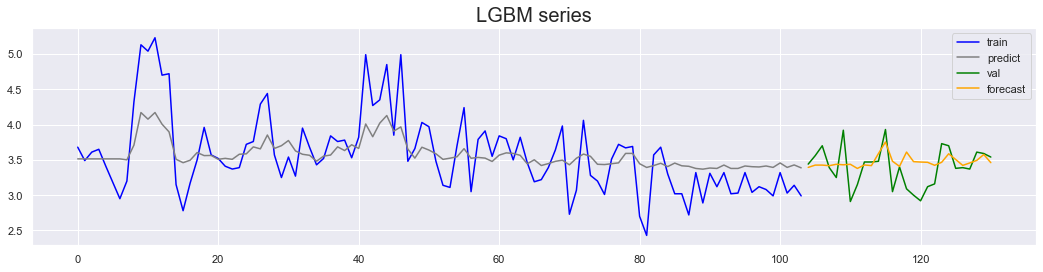

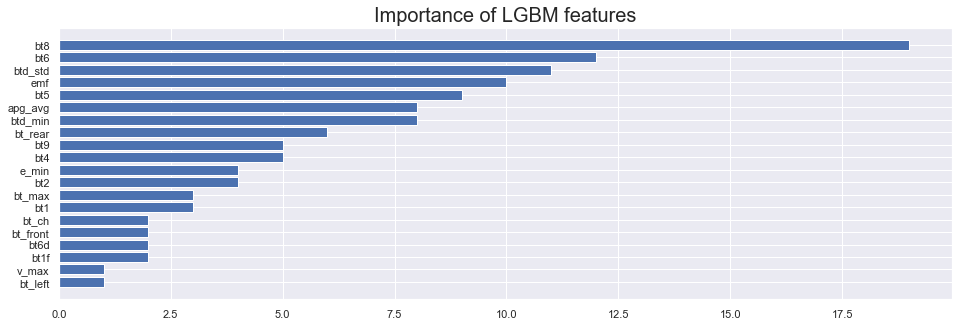

In [86]:
plot_series(y_train, y_val, y_forecast, y_pred, title='LGBM series')    

importance_chart(model.feature_importance(), model.feature_name, num_features = 20,
                 title='Importance of LGBM features')

### LightGBM hyperparameters optimization

In [87]:
""" цикл оптимизации с помощью Optuna """
def objective(trial):    
    lgb_parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    "num_leaves": trial.suggest_int("num_leaves", 10, 30),
    "max_depth": trial.suggest_int("max_depth", 6, 15),
    "lambda_l1": 1,
    "lambda_l2": 0,
#     "lambda_l1": trial.suggest_categorical("lambda_l1", [0, 0.1, 1]),
#     "lambda_l2": trial.suggest_categorical("lambda_l2", [0, 0.05, 0.1]),
    'learning_rate': trial.suggest_float("learning_rate", 0.02, 0.1),
    'feature_fraction': trial.suggest_float("feature_fraction", 0.8, 1.0),
    'bagging_fraction': trial.suggest_float("bagging_fraction", 0.7, 1.0),
    "bagging_freq":4,
    'verbose': -1,
    "min_child_samples": 10,
    'min_data_in_leaf': 4,
    'force_col_wise':True,
}   
    model = lightgbm.train(lgb_parameters, train_data, valid_sets=val_data,
                       num_boost_round=100, early_stopping_rounds=5,
                      verbose_eval=False)   
    y_forecast = model.predict(X_val)
    return sm.tools.eval_measures.rmse(y_val, y_forecast)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-02-16 00:26:22,179] A new study created in memory with name: no-name-2387b7fa-06dc-46fd-892a-15438a4a9f27
[I 2021-02-16 00:26:22,192] Trial 0 finished with value: 0.25600339137084877 and parameters: {'num_leaves': 28, 'max_depth': 9, 'learning_rate': 0.05596641649226383, 'feature_fraction': 0.9724355520486232, 'bagging_fraction': 0.8153777401036653}. Best is trial 0 with value: 0.25600339137084877.
[I 2021-02-16 00:26:22,206] Trial 1 finished with value: 0.2574456999857298 and parameters: {'num_leaves': 27, 'max_depth': 9, 'learning_rate': 0.034349964109341276, 'feature_fraction': 0.9862691583042975, 'bagging_fraction': 0.9128519934015806}. Best is trial 0 with value: 0.25600339137084877.
[I 2021-02-16 00:26:22,225] Trial 2 finished with value: 0.2532952937000302 and parameters: {'num_leaves': 20, 'max_depth': 11, 'learning_rate': 0.028176502695521945, 'feature_fraction': 0.9198185006543088, 'bagging_fraction': 0.9905299385522546}. Best is trial 2 with value: 0.2532952937000302

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:22,395] Trial 12 finished with value: 0.2638407687748859 and parameters: {'num_leaves': 20, 'max_depth': 12, 'learning_rate': 0.020722864971067727, 'feature_fraction': 0.8372080291954845, 'bagging_fraction': 0.9660013729444085}. Best is trial 10 with value: 0.25322680186644797.
[I 2021-02-16 00:26:22,427] Trial 13 finished with value: 0.2542628412161938 and parameters: {'num_leaves': 10, 'max_depth': 12, 'learning_rate': 0.04112649551930539, 'feature_fraction': 0.9289393479555875, 'bagging_fraction': 0.9522450456843504}. Best is trial 10 with value: 0.25322680186644797.
[I 2021-02-16 00:26:22,458] Trial 14 finished with value: 0.25327962968555506 and parameters: {'num_leaves': 23, 'max_depth': 6, 'learning_rate': 0.06328718583360139, 'feature_fraction': 0.8472592278413011, 'bagging_fraction': 0.995453276822523}. Best is trial 10 with value: 0.25322680186644797.
[I 2021-02-16 00:26:22,487] Trial 15 finished with value: 0.27396319831542865 and parameters: {'num_leaves

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:22,576] Trial 18 finished with value: 0.3037760914308488 and parameters: {'num_leaves': 22, 'max_depth': 7, 'learning_rate': 0.07723063309183383, 'feature_fraction': 0.8601701943681554, 'bagging_fraction': 0.7894038011817588}. Best is trial 10 with value: 0.25322680186644797.
[I 2021-02-16 00:26:22,604] Trial 19 finished with value: 0.2869816857931882 and parameters: {'num_leaves': 17, 'max_depth': 13, 'learning_rate': 0.09023192115316005, 'feature_fraction': 0.8234118063889936, 'bagging_fraction': 0.9565527113617707}. Best is trial 10 with value: 0.25322680186644797.
[I 2021-02-16 00:26:22,632] Trial 20 finished with value: 0.27393894312611533 and parameters: {'num_leaves': 22, 'max_depth': 14, 'learning_rate': 0.06431214779194998, 'feature_fraction': 0.865165739337325, 'bagging_fraction': 0.8775185370003948}. Best is trial 10 with value: 0.25322680186644797.
[I 2021-02-16 00:26:22,661] Trial 21 finished with value: 0.25317749250332144 and parameters: {'num_leaves'

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:22,786] Trial 25 finished with value: 0.25877378455107164 and parameters: {'num_leaves': 18, 'max_depth': 11, 'learning_rate': 0.07171643745009952, 'feature_fraction': 0.9349816303721228, 'bagging_fraction': 0.9029269595658146}. Best is trial 21 with value: 0.25317749250332144.
[I 2021-02-16 00:26:22,819] Trial 26 finished with value: 0.25488366307792837 and parameters: {'num_leaves': 25, 'max_depth': 14, 'learning_rate': 0.05114459456269848, 'feature_fraction': 0.9079708034008149, 'bagging_fraction': 0.995890139264122}. Best is trial 21 with value: 0.25317749250332144.
[I 2021-02-16 00:26:22,852] Trial 27 finished with value: 0.2507059512482972 and parameters: {'num_leaves': 30, 'max_depth': 12, 'learning_rate': 0.06183447521636511, 'feature_fraction': 0.8086564691190934, 'bagging_fraction': 0.956569415462453}. Best is trial 27 with value: 0.2507059512482972.
[I 2021-02-16 00:26:22,882] Trial 28 finished with value: 0.27039597670834226 and parameters: {'num_leaves'

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:22,972] Trial 31 finished with value: 0.24967803052326648 and parameters: {'num_leaves': 21, 'max_depth': 11, 'learning_rate': 0.06067217939519041, 'feature_fraction': 0.9646974792442916, 'bagging_fraction': 0.9805297960101871}. Best is trial 31 with value: 0.24967803052326648.
[I 2021-02-16 00:26:23,001] Trial 32 finished with value: 0.2507771972724524 and parameters: {'num_leaves': 21, 'max_depth': 11, 'learning_rate': 0.0711034121758064, 'feature_fraction': 0.9737061671634624, 'bagging_fraction': 0.9768950677005708}. Best is trial 31 with value: 0.24967803052326648.
[I 2021-02-16 00:26:23,029] Trial 33 finished with value: 0.24171485984076094 and parameters: {'num_leaves': 20, 'max_depth': 11, 'learning_rate': 0.07421757347468941, 'feature_fraction': 0.9985544235718283, 'bagging_fraction': 0.9123230857574985}. Best is trial 33 with value: 0.24171485984076094.
[I 2021-02-16 00:26:23,058] Trial 34 finished with value: 0.24101389937184425 and parameters: {'num_leave


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf i

[I 2021-02-16 00:26:23,172] Trial 38 finished with value: 0.26172072288157483 and parameters: {'num_leaves': 12, 'max_depth': 8, 'learning_rate': 0.09434518940104347, 'feature_fraction': 0.999999840090607, 'bagging_fraction': 0.8529991662413499}. Best is trial 36 with value: 0.23843961606562877.
[I 2021-02-16 00:26:23,201] Trial 39 finished with value: 0.23820952688013425 and parameters: {'num_leaves': 15, 'max_depth': 8, 'learning_rate': 0.08576494730887767, 'feature_fraction': 0.9884050078901326, 'bagging_fraction': 0.9203685371401705}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,230] Trial 40 finished with value: 0.2575361508000582 and parameters: {'num_leaves': 16, 'max_depth': 8, 'learning_rate': 0.07410785000379885, 'feature_fraction': 0.9769856469257884, 'bagging_fraction': 0.8892434670102628}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,259] Trial 41 finished with value: 0.24646208233535724 and parameters: {'num_leaves':

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:23,377] Trial 45 finished with value: 0.25826778291778074 and parameters: {'num_leaves': 10, 'max_depth': 10, 'learning_rate': 0.07701967398242879, 'feature_fraction': 0.999849882536964, 'bagging_fraction': 0.9229951394173461}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,406] Trial 46 finished with value: 0.2666096785749885 and parameters: {'num_leaves': 16, 'max_depth': 8, 'learning_rate': 0.08213331339390874, 'feature_fraction': 0.9803305201224494, 'bagging_fraction': 0.8889774502357569}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,434] Trial 47 finished with value: 0.2662435203859864 and parameters: {'num_leaves': 19, 'max_depth': 10, 'learning_rate': 0.09727625487103751, 'feature_fraction': 0.9630844334527271, 'bagging_fraction': 0.9302089898467131}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,461] Trial 48 finished with value: 0.2641074871715434 and parameters: {'num_leaves':

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:23,579] Trial 52 finished with value: 0.2509311950138406 and parameters: {'num_leaves': 13, 'max_depth': 10, 'learning_rate': 0.09256580796911287, 'feature_fraction': 0.9962901115737571, 'bagging_fraction': 0.9182333085094273}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,609] Trial 53 finished with value: 0.2586669178300457 and parameters: {'num_leaves': 12, 'max_depth': 9, 'learning_rate': 0.08452809459316167, 'feature_fraction': 0.9738089637543333, 'bagging_fraction': 0.8825752340299586}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,636] Trial 54 finished with value: 0.2571981695128439 and parameters: {'num_leaves': 14, 'max_depth': 8, 'learning_rate': 0.0796591034274786, 'feature_fraction': 0.9995450927811231, 'bagging_fraction': 0.9061080561395947}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,664] Trial 55 finished with value: 0.2595226906332888 and parameters: {'num_leaves': 1

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:23,784] Trial 59 finished with value: 0.2869790634740519 and parameters: {'num_leaves': 18, 'max_depth': 11, 'learning_rate': 0.09662339457664669, 'feature_fraction': 0.955527693528902, 'bagging_fraction': 0.821486781834175}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,810] Trial 60 finished with value: 0.33583071957268285 and parameters: {'num_leaves': 17, 'max_depth': 8, 'learning_rate': 0.0688496874352432, 'feature_fraction': 0.9796321155407283, 'bagging_fraction': 0.7942631779783715}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,841] Trial 61 finished with value: 0.25328083315753125 and parameters: {'num_leaves': 20, 'max_depth': 9, 'learning_rate': 0.08694073823161709, 'feature_fraction': 0.9937455861704394, 'bagging_fraction': 0.9296662424320095}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:23,870] Trial 62 finished with value: 0.24585403124721739 and parameters: {'num_leaves': 

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:23,985] Trial 66 finished with value: 0.2513365570916944 and parameters: {'num_leaves': 16, 'max_depth': 12, 'learning_rate': 0.0788227198917003, 'feature_fraction': 0.9798518781256815, 'bagging_fraction': 0.9148634902281074}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:24,017] Trial 67 finished with value: 0.2573986701548522 and parameters: {'num_leaves': 17, 'max_depth': 11, 'learning_rate': 0.0737202350990951, 'feature_fraction': 0.9911342364700487, 'bagging_fraction': 0.9259530117569712}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:24,051] Trial 68 finished with value: 0.2561338185391135 and parameters: {'num_leaves': 20, 'max_depth': 11, 'learning_rate': 0.07924214434731155, 'feature_fraction': 0.9695258603330095, 'bagging_fraction': 0.9584557728035855}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:24,083] Trial 69 finished with value: 0.26734283258202035 and parameters: {'num_leaves':

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:24,165] Trial 72 finished with value: 0.24516612126497458 and parameters: {'num_leaves': 13, 'max_depth': 9, 'learning_rate': 0.07577111991090606, 'feature_fraction': 0.9861672027771905, 'bagging_fraction': 0.9119639088209294}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:24,196] Trial 73 finished with value: 0.2530371352194774 and parameters: {'num_leaves': 11, 'max_depth': 10, 'learning_rate': 0.08328588339264514, 'feature_fraction': 0.9941092746592851, 'bagging_fraction': 0.887678179952481}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:24,224] Trial 74 finished with value: 0.26210316853843874 and parameters: {'num_leaves': 18, 'max_depth': 9, 'learning_rate': 0.08987719245227574, 'feature_fraction': 0.9795024322127461, 'bagging_fraction': 0.8744257937931535}. Best is trial 39 with value: 0.23820952688013425.
[I 2021-02-16 00:26:24,255] Trial 75 finished with value: 0.25397779435566176 and parameters: {'num_leaves'

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:24,353] Trial 78 finished with value: 0.23662043861939092 and parameters: {'num_leaves': 12, 'max_depth': 7, 'learning_rate': 0.07125621709173906, 'feature_fraction': 0.9866893737982839, 'bagging_fraction': 0.9153712884289331}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,388] Trial 79 finished with value: 0.2475819124089052 and parameters: {'num_leaves': 11, 'max_depth': 6, 'learning_rate': 0.07300742815948154, 'feature_fraction': 0.986187442713562, 'bagging_fraction': 0.918938457417449}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,418] Trial 80 finished with value: 0.26385371772373795 and parameters: {'num_leaves': 12, 'max_depth': 7, 'learning_rate': 0.07164598204135182, 'feature_fraction': 0.9893830983968803, 'bagging_fraction': 0.9359953890247666}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,447] Trial 81 finished with value: 0.2614072308301619 and parameters: {'num_leaves': 1

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:24,559] Trial 85 finished with value: 0.2681827851139454 and parameters: {'num_leaves': 20, 'max_depth': 8, 'learning_rate': 0.0645194311903896, 'feature_fraction': 0.9705137392356443, 'bagging_fraction': 0.9647415152793266}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,588] Trial 86 finished with value: 0.2607385186406676 and parameters: {'num_leaves': 11, 'max_depth': 7, 'learning_rate': 0.08082113571958187, 'feature_fraction': 0.9885082433147607, 'bagging_fraction': 0.9488376987619918}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,617] Trial 87 finished with value: 0.2663891921323911 and parameters: {'num_leaves': 14, 'max_depth': 8, 'learning_rate': 0.08349332417674514, 'feature_fraction': 0.9836853533328681, 'bagging_fraction': 0.8924233998418979}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,646] Trial 88 finished with value: 0.29349657221401054 and parameters: {'num_leaves': 1

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:24,740] Trial 91 finished with value: 0.24073863022432732 and parameters: {'num_leaves': 13, 'max_depth': 10, 'learning_rate': 0.08042140887994537, 'feature_fraction': 0.9972695721703886, 'bagging_fraction': 0.9048283512605512}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,772] Trial 92 finished with value: 0.24302726389769055 and parameters: {'num_leaves': 13, 'max_depth': 10, 'learning_rate': 0.07987184870806259, 'feature_fraction': 0.9997981835363485, 'bagging_fraction': 0.9137497525602338}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,803] Trial 93 finished with value: 0.25587592109645396 and parameters: {'num_leaves': 13, 'max_depth': 10, 'learning_rate': 0.07962928221585615, 'feature_fraction': 0.9990909184081781, 'bagging_fraction': 0.8842142961101902}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,834] Trial 94 finished with value: 0.2594202535480254 and parameters: {'num_leav

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:24,956] Trial 98 finished with value: 0.24977182756411043 and parameters: {'num_leaves': 15, 'max_depth': 10, 'learning_rate': 0.07104465408874229, 'feature_fraction': 0.9831694239633977, 'bagging_fraction': 0.9097625358055615}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:24,987] Trial 99 finished with value: 0.2436297765424449 and parameters: {'num_leaves': 16, 'max_depth': 11, 'learning_rate': 0.07754034881543416, 'feature_fraction': 0.9941278392197321, 'bagging_fraction': 0.9330121604567339}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,018] Trial 100 finished with value: 0.24989357059563544 and parameters: {'num_leaves': 11, 'max_depth': 12, 'learning_rate': 0.08313263213926385, 'feature_fraction': 0.9777412625636348, 'bagging_fraction': 0.9203113933522693}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,045] Trial 101 finished with value: 0.26965067664094605 and parameters: {'num_le

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:25,141] Trial 104 finished with value: 0.25543918565449997 and parameters: {'num_leaves': 17, 'max_depth': 10, 'learning_rate': 0.08690925574140489, 'feature_fraction': 0.9918766323076141, 'bagging_fraction': 0.925108755839189}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,173] Trial 105 finished with value: 0.25085336105804323 and parameters: {'num_leaves': 14, 'max_depth': 9, 'learning_rate': 0.08865924593781707, 'feature_fraction': 0.9822419357240557, 'bagging_fraction': 0.9102717035347011}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,208] Trial 106 finished with value: 0.24742220355252026 and parameters: {'num_leaves': 22, 'max_depth': 11, 'learning_rate': 0.07893037129712127, 'feature_fraction': 0.9999241586888036, 'bagging_fraction': 0.8971490992170645}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,239] Trial 107 finished with value: 0.25038429314365995 and parameters: {'num_l

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:25,338] Trial 110 finished with value: 0.24710287244344975 and parameters: {'num_leaves': 13, 'max_depth': 7, 'learning_rate': 0.08103737802065765, 'feature_fraction': 0.9925272452148799, 'bagging_fraction': 0.9327877409569222}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,374] Trial 111 finished with value: 0.24364674796996313 and parameters: {'num_leaves': 15, 'max_depth': 11, 'learning_rate': 0.07771062044960055, 'feature_fraction': 0.9959430991393545, 'bagging_fraction': 0.9334426605195669}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,409] Trial 112 finished with value: 0.2533461578710942 and parameters: {'num_leaves': 16, 'max_depth': 11, 'learning_rate': 0.08466207151654923, 'feature_fraction': 0.9836529436547813, 'bagging_fraction': 0.9197096493795093}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,440] Trial 113 finished with value: 0.24485003426075616 and parameters: {'num_l

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:25,537] Trial 116 finished with value: 0.2608589541779379 and parameters: {'num_leaves': 11, 'max_depth': 12, 'learning_rate': 0.0764926221377283, 'feature_fraction': 0.9997619399127754, 'bagging_fraction': 0.9246076634462954}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,568] Trial 117 finished with value: 0.25131290712861154 and parameters: {'num_leaves': 19, 'max_depth': 10, 'learning_rate': 0.08561725056452286, 'feature_fraction': 0.9750158421602692, 'bagging_fraction': 0.9150843642498033}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,600] Trial 118 finished with value: 0.2492932528515427 and parameters: {'num_leaves': 15, 'max_depth': 11, 'learning_rate': 0.06588428548910968, 'feature_fraction': 0.9957755400009018, 'bagging_fraction': 0.9081702644192471}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,632] Trial 119 finished with value: 0.2618070933418244 and parameters: {'num_lea

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:25,731] Trial 122 finished with value: 0.24337420168164364 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.07747134342198, 'feature_fraction': 0.9961134147929657, 'bagging_fraction': 0.9327647331289055}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,763] Trial 123 finished with value: 0.2505189548139112 and parameters: {'num_leaves': 13, 'max_depth': 12, 'learning_rate': 0.07542581008168618, 'feature_fraction': 0.9880139020355301, 'bagging_fraction': 0.9181501381782716}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,794] Trial 124 finished with value: 0.25054686346795996 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.08038832883092156, 'feature_fraction': 0.9929179905686771, 'bagging_fraction': 0.9006265377638677}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,826] Trial 125 finished with value: 0.2616826427336441 and parameters: {'num_leav

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:25,928] Trial 128 finished with value: 0.2554509693510178 and parameters: {'num_leaves': 12, 'max_depth': 10, 'learning_rate': 0.07212911134082413, 'feature_fraction': 0.9282587462204193, 'bagging_fraction': 0.9589915480988979}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,958] Trial 129 finished with value: 0.2649309204756164 and parameters: {'num_leaves': 14, 'max_depth': 12, 'learning_rate': 0.07678626067737201, 'feature_fraction': 0.9865039380193726, 'bagging_fraction': 0.9060038813153743}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:25,987] Trial 130 finished with value: 0.25830083809096255 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.0814796518170054, 'feature_fraction': 0.9918033390667452, 'bagging_fraction': 0.8923502365723023}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,019] Trial 131 finished with value: 0.24370172847968485 and parameters: {'num_le

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:26,114] Trial 134 finished with value: 0.25208447173265625 and parameters: {'num_leaves': 14, 'max_depth': 10, 'learning_rate': 0.08415957971344733, 'feature_fraction': 0.9898241202107438, 'bagging_fraction': 0.8007626869785245}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,150] Trial 135 finished with value: 0.25228080024322214 and parameters: {'num_leaves': 15, 'max_depth': 11, 'learning_rate': 0.0747612499626124, 'feature_fraction': 0.9962862189484187, 'bagging_fraction': 0.9504876761174899}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,182] Trial 136 finished with value: 0.2517444187225923 and parameters: {'num_leaves': 11, 'max_depth': 9, 'learning_rate': 0.08585255689703211, 'feature_fraction': 0.9850429737241225, 'bagging_fraction': 0.910802664829658}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,215] Trial 137 finished with value: 0.2573907279203103 and parameters: {'num_leav

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:26,316] Trial 140 finished with value: 0.250249673710828 and parameters: {'num_leaves': 16, 'max_depth': 10, 'learning_rate': 0.07801527733606234, 'feature_fraction': 0.9997089242262381, 'bagging_fraction': 0.8992879786008474}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,350] Trial 141 finished with value: 0.24355718994580103 and parameters: {'num_leaves': 15, 'max_depth': 11, 'learning_rate': 0.0772041526157583, 'feature_fraction': 0.996061118738567, 'bagging_fraction': 0.9415414674726982}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,385] Trial 142 finished with value: 0.24561563034844017 and parameters: {'num_leaves': 15, 'max_depth': 11, 'learning_rate': 0.07583130514300554, 'feature_fraction': 0.9949732973015152, 'bagging_fraction': 0.9388615087580161}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,421] Trial 143 finished with value: 0.24681836649893923 and parameters: {'num_lea

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:26,521] Trial 146 finished with value: 0.25573579909512917 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.09065531313793726, 'feature_fraction': 0.9916656209962615, 'bagging_fraction': 0.908157869274879}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,548] Trial 147 finished with value: 0.26988478465582155 and parameters: {'num_leaves': 14, 'max_depth': 6, 'learning_rate': 0.08442031343138315, 'feature_fraction': 0.9817747031875509, 'bagging_fraction': 0.966140426407561}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,580] Trial 148 finished with value: 0.24492222549192066 and parameters: {'num_leaves': 13, 'max_depth': 10, 'learning_rate': 0.08791720006309882, 'feature_fraction': 0.9895482672030957, 'bagging_fraction': 0.8851875164257565}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,613] Trial 149 finished with value: 0.24450111785982848 and parameters: {'num_le

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:26,715] Trial 152 finished with value: 0.25491711723576793 and parameters: {'num_leaves': 16, 'max_depth': 11, 'learning_rate': 0.07448908958912619, 'feature_fraction': 0.9963709347812646, 'bagging_fraction': 0.9227652586319057}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,751] Trial 153 finished with value: 0.25380744869009664 and parameters: {'num_leaves': 15, 'max_depth': 11, 'learning_rate': 0.07644569038787914, 'feature_fraction': 0.9871358291320559, 'bagging_fraction': 0.905090218089969}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,783] Trial 154 finished with value: 0.2524210076396952 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.08302497457671013, 'feature_fraction': 0.9930987032572847, 'bagging_fraction': 0.914766318925952}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,816] Trial 155 finished with value: 0.2526333322729075 and parameters: {'num_lea

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:26,916] Trial 158 finished with value: 0.24757354746484456 and parameters: {'num_leaves': 13, 'max_depth': 7, 'learning_rate': 0.07963929949493734, 'feature_fraction': 0.9964520223641559, 'bagging_fraction': 0.9205975986990382}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,949] Trial 159 finished with value: 0.24476212297686256 and parameters: {'num_leaves': 14, 'max_depth': 8, 'learning_rate': 0.08193547504769183, 'feature_fraction': 0.9808619814296143, 'bagging_fraction': 0.9095377221399836}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:26,981] Trial 160 finished with value: 0.24417824165538618 and parameters: {'num_leaves': 15, 'max_depth': 12, 'learning_rate': 0.07513629816881105, 'feature_fraction': 0.9998490108210714, 'bagging_fraction': 0.9166276009130903}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,014] Trial 161 finished with value: 0.24785211195053858 and parameters: {'num_l

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:27,119] Trial 164 finished with value: 0.24873638845298912 and parameters: {'num_leaves': 16, 'max_depth': 11, 'learning_rate': 0.07960856980490513, 'feature_fraction': 0.9880640333010476, 'bagging_fraction': 0.9359797325249127}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,157] Trial 165 finished with value: 0.25182525452991966 and parameters: {'num_leaves': 13, 'max_depth': 10, 'learning_rate': 0.07748528144660825, 'feature_fraction': 0.9961656794141976, 'bagging_fraction': 0.9484526828615095}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,191] Trial 166 finished with value: 0.2575466200367665 and parameters: {'num_leaves': 14, 'max_depth': 11, 'learning_rate': 0.07337851508785423, 'feature_fraction': 0.9921196667252052, 'bagging_fraction': 0.9245327403717446}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,225] Trial 167 finished with value: 0.25048591801959813 and parameters: {'num_

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:27,291] Trial 169 finished with value: 0.24832330830285892 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.08675429152707123, 'feature_fraction': 0.974483412664489, 'bagging_fraction': 0.9117294271288684}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,319] Trial 170 finished with value: 0.33047861435748216 and parameters: {'num_leaves': 12, 'max_depth': 10, 'learning_rate': 0.08095131921772189, 'feature_fraction': 0.9887795625019463, 'bagging_fraction': 0.827442103798455}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,354] Trial 171 finished with value: 0.2483659962628576 and parameters: {'num_leaves': 15, 'max_depth': 11, 'learning_rate': 0.078545442985123, 'feature_fraction': 0.9999515467222859, 'bagging_fraction': 0.9332660837150774}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,388] Trial 172 finished with value: 0.2450955383026248 and parameters: {'num_leave

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:27,492] Trial 175 finished with value: 0.25743078320391477 and parameters: {'num_leaves': 16, 'max_depth': 11, 'learning_rate': 0.0823131828191122, 'feature_fraction': 0.9912782793649625, 'bagging_fraction': 0.9451037093123947}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,527] Trial 176 finished with value: 0.25457956188814096 and parameters: {'num_leaves': 14, 'max_depth': 12, 'learning_rate': 0.08070012679494633, 'feature_fraction': 0.9837510278451366, 'bagging_fraction': 0.9343188964219729}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,561] Trial 177 finished with value: 0.24718286519668772 and parameters: {'num_leaves': 17, 'max_depth': 10, 'learning_rate': 0.0742016649267044, 'feature_fraction': 0.9954357304359019, 'bagging_fraction': 0.9169607985901893}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,595] Trial 178 finished with value: 0.24895358528769224 and parameters: {'num_l

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:27,697] Trial 181 finished with value: 0.25115943407195784 and parameters: {'num_leaves': 12, 'max_depth': 11, 'learning_rate': 0.08461567936811862, 'feature_fraction': 0.9923604445204212, 'bagging_fraction': 0.9297823467208695}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,730] Trial 182 finished with value: 0.2431397658771962 and parameters: {'num_leaves': 12, 'max_depth': 11, 'learning_rate': 0.07957476027565227, 'feature_fraction': 0.9966936452758378, 'bagging_fraction': 0.912917855683362}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,763] Trial 183 finished with value: 0.2510816708144279 and parameters: {'num_leaves': 11, 'max_depth': 11, 'learning_rate': 0.08298578984404514, 'feature_fraction': 0.9967223486041227, 'bagging_fraction': 0.9013835208362964}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,795] Trial 184 finished with value: 0.24145656387693867 and parameters: {'num_le

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:27,896] Trial 187 finished with value: 0.24661275747897324 and parameters: {'num_leaves': 12, 'max_depth': 12, 'learning_rate': 0.08528417543925555, 'feature_fraction': 0.9932523191785502, 'bagging_fraction': 0.9155825926501868}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,926] Trial 188 finished with value: 0.30799101087950853 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.0813690313226482, 'feature_fraction': 0.9991842835366084, 'bagging_fraction': 0.8443829540537697}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,957] Trial 189 finished with value: 0.2576375821240254 and parameters: {'num_leaves': 11, 'max_depth': 10, 'learning_rate': 0.08405330857920917, 'feature_fraction': 0.9795586026688559, 'bagging_fraction': 0.9080693793061078}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:27,989] Trial 190 finished with value: 0.26445827012718864 and parameters: {'num_l

min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_sam

[I 2021-02-16 00:26:28,090] Trial 193 finished with value: 0.23926295358658836 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.07934118711765809, 'feature_fraction': 0.9925112423930766, 'bagging_fraction': 0.9138446299288546}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:28,125] Trial 194 finished with value: 0.24528003851425748 and parameters: {'num_leaves': 13, 'max_depth': 11, 'learning_rate': 0.0825682093916158, 'feature_fraction': 0.999950420246819, 'bagging_fraction': 0.9140930104461457}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:28,158] Trial 195 finished with value: 0.25359717479178445 and parameters: {'num_leaves': 12, 'max_depth': 11, 'learning_rate': 0.07941601681103345, 'feature_fraction': 0.9999896435007504, 'bagging_fraction': 0.8970770452068355}. Best is trial 78 with value: 0.23662043861939092.
[I 2021-02-16 00:26:28,191] Trial 196 finished with value: 0.26348331010033543 and parameters: {'num_l

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is

[I 2021-02-16 00:26:28,292] Trial 199 finished with value: 0.24934606471841758 and parameters: {'num_leaves': 12, 'max_depth': 10, 'learning_rate': 0.08105082774635755, 'feature_fraction': 0.9998639594186824, 'bagging_fraction': 0.9113745588430069}. Best is trial 78 with value: 0.23662043861939092.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
Number of finished trials: 200
Best trial:
  Value: 0.23662043861939092
  Params: 
    num_leaves: 12
    max_depth: 7
    learning_rate: 0.07125621709173906
    feature_fraction: 0.9866893737982839
    bagging_fraction: 0.9153712884289331


In [88]:
""" LGBM run after optimization """

cat_features = ['minofday', 'dow']
train_data = lightgbm.Dataset(X_train, label=y_train,
                              categorical_feature=cat_features,
                              feature_name=train_cols,
                              free_raw_data=False)
val_data = lightgbm.Dataset(X_val, label=y_val,
                            categorical_feature=cat_features,)

lgb_parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 12,
    'max_depth': 7,
    "lambda_l1": 1,
    "lambda_l2": 0,
    'learning_rate': 0.071,
    'feature_fraction': 0.98,
    'bagging_fraction': 0.91,
    'bagging_freq': 4,
    'verbose': -1,
    'min_data_in_leaf': 4,
    "min_child_samples": 10,
    'force_col_wise': True,
}

model = lightgbm.train(lgb_parameters, train_data, valid_sets=val_data,
                       num_boost_round=100, early_stopping_rounds=5,
                       verbose_eval=-1)

y_pred = model.predict(X_train)
y_forecast = model.predict(X_val)
print(
    f"LGBM RMSE result: {sm.tools.eval_measures.rmse(y_val, y_forecast):.4f} after {model.current_iteration()} iters")

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 0.244374
LGBM RMSE result: 0.2444 after 19 iters


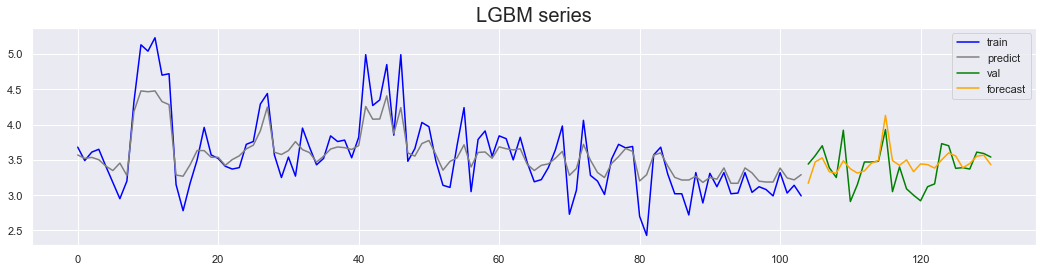

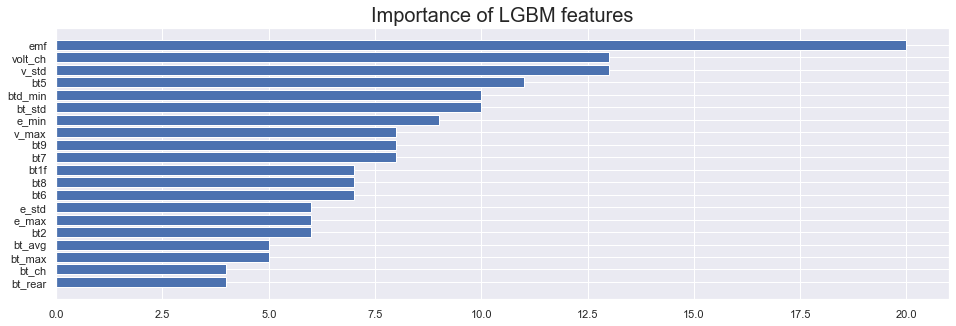

In [89]:
plot_series(y_train, y_val, y_forecast, y_pred, title='LGBM series')    

importance_chart(model.feature_importance(), model.feature_name, num_features = 20,
                 title='Importance of LGBM features')

In [101]:
""" select for final model only features with importance >= 3"""
min_importance = 3
important_features = [fn for fn, imp in zip(model.feature_name(), model.feature_importance()) if imp >= min_importance] 
print (important_features)

['emf', 'volt', 'bt1', 'bt2', 'bt4', 'bt5', 'bt6', 'bt7', 'bt8', 'bt9', 'bt10', 'bt1f', 'bt1d', 'bt6d', 'bt_max', 'bt_std', 'bt_avg', 'bt_rear', 'bt_right', 'btd_min', 'v_max', 'v_std', 'e_min', 'e_max', 'e_std', 'volt_ch', 'bt_ch']


# Prepare final submission

In [109]:
train_cols = important_features
cat_features = [c for c in cat_features if c in important_features]


df_final = df.loc[df.part.isin(['train', 'val', 'test']), ['target','part', *train_cols]]
test_size = df_final[df_final.part == 'test'].shape[0]
print('test_size', test_size)
del df_final['part']

X_train_final, X_test, y_train_final, _ = bulid_train_test_sets(df_final, train_cols,
                                                       test_size=test_size)

test_size 35


In [113]:
""" run final model wiht same params as most successful model above 
for same number of iterations"""

train_data = lightgbm.Dataset(X_train_final, label=y_train_final,
                              categorical_feature=cat_features,
                              feature_name=train_cols,
                              free_raw_data=True)
# val_data = lightgbm.Dataset(X_val, label=y_val,
#                             categorical_feature=cat_features,)


lgb_parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 12,
    'max_depth': 7,
    "lambda_l1": 1,
    "lambda_l2": 0,
    'learning_rate': 0.071,
    'feature_fraction': 0.98,
    'bagging_fraction': 0.91,
    'bagging_freq': 4,
    'verbose': 1,
    'min_data_in_leaf': 4,
    'force_col_wise': True,
}

model_final = lightgbm.train(lgb_parameters, train_data, 
                       num_boost_round=19,
                       verbose_eval=1)

y_test = model_final.predict(X_test)

[LightGBM] [Info] Total Bins 999
[LightGBM] [Info] Number of data points in the train set: 131, number of used features: 27
[LightGBM] [Info] Start training from score 3.539466


In [118]:
submission = df.loc[df.part == 'test', ['timestamp', 'target']].copy()
submission.target = y_test.round(4)

In [120]:
submission.to_csv('submission.csv', index=False)